# Preparation

In [1]:
%%capture
!pip install torchattacks

## Download & Extract Adaptive Exposures

In [2]:
%%capture
!pip install gdown
!gdown 1bYjImEFjYTjxR7tw8bnqN3iFmdcomCVu
# https://drive.google.com/file/d/1bYjImEFjYTjxR7tw8bnqN3iFmdcomCVu/view?usp=sharing

In [3]:
%%capture
!mkdir ./AdaptiveExposure/
!unzip ./tumor-detection-exposure.zip -d ./AdaptiveExposure/

## Download & Extract Tiny ImageNet

In [4]:
%%capture
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

## Use CUDA

In [5]:
!nvidia-smi

Wed May 24 13:57:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


# Datasets

## Tumor Detection

In [7]:
import os
from glob import glob
import shutil
import random
import subprocess
import zipfile
import time
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd 
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2


class TumorDetection(torch.utils.data.Dataset):
    def __init__(self, transform=None, train=True, count=None):
        self._download_and_extract()
        self.transform = transform
        if train:
            self.image_files = glob(
                os.path.join( './MRI', "Training", "notumor", "*.jpg")
            )
        else:
          image_files = glob(os.path.join( './MRI', "Testing", "*", "*.jpg"))
          normal_image_files = glob(os.path.join( './MRI', "./Testing", "notumor", "*.jpg"))
          anomaly_image_files = list(set(image_files) - set(normal_image_files))
          self.image_files = image_files

        if count is not None:
            if count > len(self.image_files):
                self.image_files = self._oversample(count)
            else:
                self.image_files  = self._undersample(count)

        self.image_files.sort(key=lambda y: y.lower())
        self.train = train
    
    def _download_and_extract(self):
        google_id = '1AOPOfQ05aSrr2RkILipGmEkgLDrZCKz_'
        file_path = os.path.join('./MRI', 'Training')

        if os.path.exists(file_path):
            return

        if not os.path.exists('./MRI'):
            os.makedirs('./MRI')

        if not os.path.exists(file_path):
            subprocess.run(['gdown', google_id, '-O', './MRI/archive(3).zip'])
        
        with zipfile.ZipFile("./MRI/archive(3).zip", 'r') as zip_ref:
            zip_ref.extractall("./MRI/")

        os.rename(  "./MRI/Training/glioma", "./MRI/Training/glioma_tr")
        os.rename(  "./MRI/Training/meningioma", "./MRI/Training/meningioma_tr")
        os.rename(  "./MRI/Training/pituitary", "./MRI/Training/pituitary_tr")
        
        shutil.move("./MRI/Training/glioma_tr","./MRI/Testing")
        shutil.move("./MRI/Training/meningioma_tr","./MRI/Testing")
        shutil.move("./MRI/Training/pituitary_tr","./MRI/Testing")


    def __getitem__(self, index):
        image_file = self.image_files[index]
        image = Image.open(image_file)
        image = image.convert('RGB')
        image = image.resize((256, 256))
        
        if self.transform:
            if isinstance(self.transform, A.core.composition.Compose):
                image = self.transform(image=np.array(image))['image']/255
            else:
                image = self.transform(image)
        
        if "notumor" in os.path.dirname(image_file):
            target = 0
        else:
            target = 1

        return image, target

    def __len__(self):
        return len(self.image_files)


    def _oversample(self, count):
        num_extra_samples = count - len(self.image_files)
        extra_image_files = [random.choice(self.image_files) for _ in range(num_extra_samples)]

        return self.image_files + extra_image_files

    def _undersample(self, count):
        indices = random.sample(range(len(self.image_files)), count)
        new_image_files = [self.image_files[idx] for idx in indices]

        return new_image_files

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Testset

In [8]:
test_transform = A.Compose([
    A.ToGray(p=1.0),
    A.Resize(224, 224),
    ToTensorV2()
])

test_dataset = TumorDetection(test_transform, train=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1AOPOfQ05aSrr2RkILipGmEkgLDrZCKz_
From (redirected): https://drive.google.com/uc?id=1AOPOfQ05aSrr2RkILipGmEkgLDrZCKz_&confirm=t&uuid=e19663ba-1aee-4a74-b7aa-bebc9212c12d
To: /kaggle/working/MRI/archive(3).zip
100%|██████████| 156M/156M [00:01<00:00, 113MB/s]  


#### Visualize Testset

In [9]:
def visualize_samples(dataloader, n, title="Sample"):
    normal_samples = []
    abnormal_samples = []

    def to_3_channels(image):
        if image.shape[0] == 1:
            return image.repeat(3, 1, 1)
        return image

    # Collect n x n samples
    for images, labels in dataloader:
        for i, l in enumerate(labels):
            image = to_3_channels(images[i])
            if len(normal_samples) < n * n and l == 0:
                normal_samples.append(image)
            elif len(abnormal_samples) < n * n and l != 0:
                abnormal_samples.append(image)
            if len(normal_samples) == n * n and len(abnormal_samples) == n * n:
                break
        if len(normal_samples) == n * n and len(abnormal_samples) == n * n:
            break

    normal_grid = torchvision.utils.make_grid(normal_samples, nrow=n)
    abnormal_grid = torchvision.utils.make_grid(abnormal_samples, nrow=n)


    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    fig.patch.set_alpha(0)
    fig.suptitle(title, fontsize=16)

    axs[0].imshow(normal_grid.permute(1, 2, 0))
    axs[0].set_title('Normal', fontsize=14)
    axs[0].axis('off')

    axs[1].imshow(abnormal_grid.permute(1, 2, 0))
    axs[1].set_title('Abnormal', fontsize=14)
    axs[1].axis('off')

    plt.show()

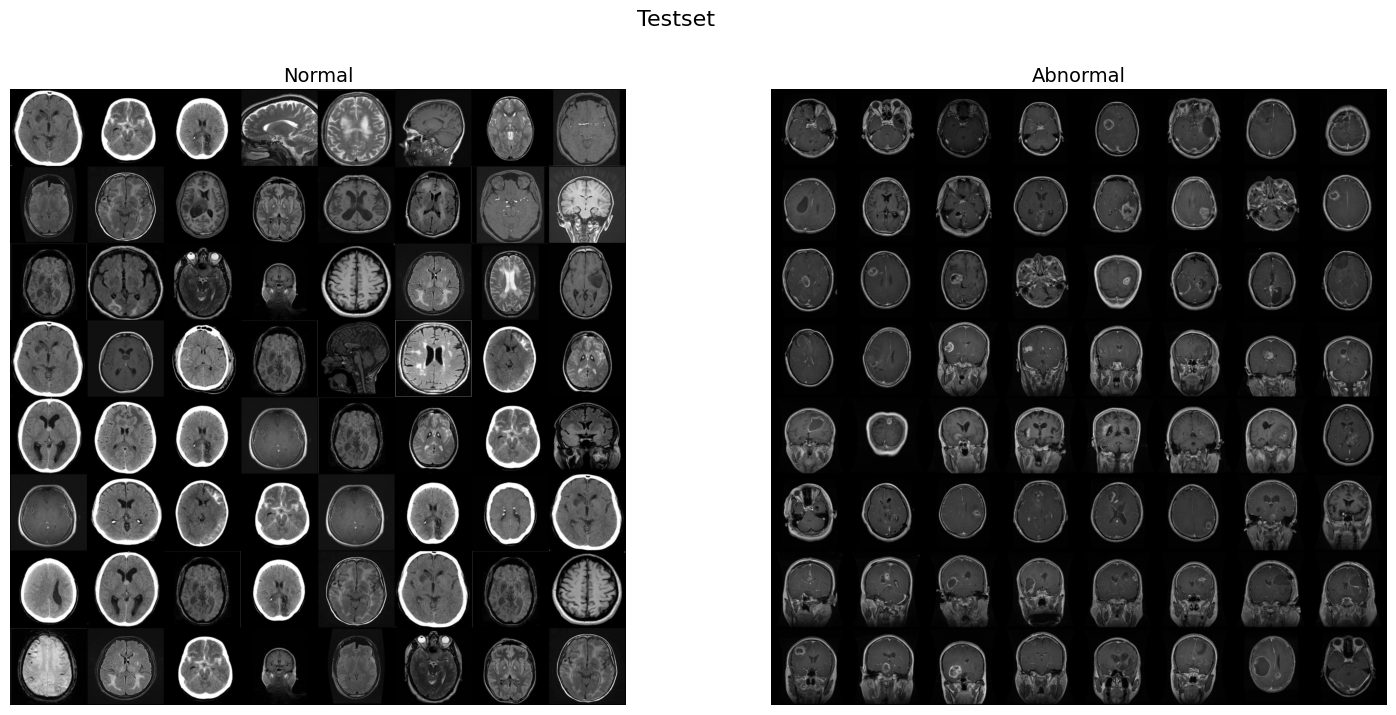

In [10]:
visualize_samples(test_loader, 8, "Testset")

## Adaptive & Tiny ImageNet Datasets

In [11]:
class AdaptiveExposure(Dataset):
    def __init__(self, root, transform, count=None):
        super(AdaptiveExposure, self).__init__()
        self.root = root
        self.image_files = glob(os.path.join(root, '**', "*.png"), recursive=True)
        self.transform = transform
        if count is not None:
            if count > len(self.image_files):
                self.image_files = self._oversample(count)
            else:
                self.image_files = self._undersample(count)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image = Image.open(image_file)
        image = image.convert('RGB')
        image = image.resize((256, 256))
        
        if self.transform:
            if isinstance(self.transform, A.core.composition.Compose):
                image = self.transform(image=np.array(image))['image']/255
            else:
                image = self.transform(image)
        
        return image, 1

    def _oversample(self, count):
        num_extra_samples = count - len(self.image_files)
        extra_image_files = [random.choice(self.image_files) for _ in range(num_extra_samples)]

        return self.image_files + extra_image_files

    def _undersample(self, count):
        indices = random.sample(range(len(self.image_files)), count)
        new_image_files = [self.image_files[idx] for idx in indices]

        return new_image_files



class ImageNetExposure(Dataset):
    def __init__(self, root, count, transform=None):
        self.transform = transform
        image_files = glob(os.path.join(root, "**", "*.JPEG"), recursive=True)
        random.shuffle(image_files)
        final_length =  min(len(image_files), count) 
        self.image_files = image_files[:final_length]

        self.image_files.sort(key=lambda y: y.lower())

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image = Image.open(image_file)
        image = image.convert('RGB')
        image = image.resize((256, 256))
        
        
        if self.transform:
            if isinstance(self.transform, A.core.composition.Compose):
                image = self.transform(image=np.array(image))['image']/255
            else:
                image = self.transform(image)

        return image, 1

    def __len__(self):
        return len(self.image_files)

# Model

In [12]:
import torch.nn as nn

mu = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

mu = torch.tensor(mu).view(3,1,1).to(device)
std = torch.tensor(std).view(3,1,1).to(device)

class AdaptedModel(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.norm = lambda x: ( x - mu ) / std
        self.pretrained_model = pretrained_model
        in_feaures = self.pretrained_model.fc.in_features
        self.pretrained_model.fc = nn.Linear(in_feaures,  2)  # Replace the logits layer with an identity function

    def forward(self, x):
        x = self.norm(x)
        x = self.pretrained_model(x)
        return x

# Utils

In [13]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import csv

def auc_softmax_adversarial(model, test_loader, test_attack, device, num_classes):

    is_train = model.training
    model.eval()

    soft = torch.nn.Softmax(dim=1)
    anomaly_scores = []
    preds = []
    test_labels = []

    with tqdm(test_loader, unit="batch") as tepoch:
        torch.cuda.empty_cache()
        for i, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)

            adv_data = test_attack(data, target)
            output = model(adv_data)

            probs = soft(output).squeeze()
            anomaly_scores += probs[:, num_classes].detach().cpu().numpy().tolist()

            target = target == num_classes
            
            test_labels += target.detach().cpu().numpy().tolist()

    auc = roc_auc_score(test_labels, anomaly_scores)

    if is_train:
        model.train()
    else:
        model.eval()

    return auc

def auc_softmax(model, test_loader, device, num_classes):

    is_train = model.training
    model.eval()

    soft = torch.nn.Softmax(dim=1)
    anomaly_scores = []
    preds = []
    test_labels = []

    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            torch.cuda.empty_cache()
            for i, (data, target) in enumerate(tepoch):
                data, target = data.to(device), target.to(device)

                output = model(data)

                probs = soft(output).squeeze()
                anomaly_scores += probs[:, num_classes].detach().cpu().numpy().tolist()

                target = target == num_classes
                
                test_labels += target.detach().cpu().numpy().tolist()

    auc = roc_auc_score(test_labels, anomaly_scores)

    if is_train:
        model.train()
    else:
        model.eval()

    return auc


lr_schedule = lambda learning_rate, t, max_epochs: np.interp([t], [0, max_epochs // 3, max_epochs * 2 // 3, max_epochs], [learning_rate, learning_rate/10, learning_rate / 100, 0])[0]

def run(model, train_attack, test_attack, trainloader, testloader, test_step:int, max_epochs:int, device, loss_threshold=1e-3, num_classes=10, learning_rate=0.1):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    
    criterion = nn.CrossEntropyLoss()

    init_epoch = 0

    print(f'Starting Run from epoch {init_epoch}')
    
    for epoch in range(init_epoch, max_epochs):
    
        torch.cuda.empty_cache()

        print(f'====== Starting Training on epoch {epoch}')
        train_loss = train_one_epoch(epoch=epoch,\
                                    max_epochs=max_epochs, \
                                    model=model,\
                                    optimizer=optimizer,
                                    criterion=criterion,\
                                    trainloader=trainloader,\
                                    train_attack=train_attack,\
                                    lr=learning_rate,\
                                    device=device)
        
        print("train loss is ", train_loss)
        
        if train_loss < loss_threshold:
            break

        if epoch % test_step == 0 :

            print(f'AUC Vanila - Started...')
            clean_auc  = auc_softmax(model=model,  test_loader=testloader, device=device, num_classes=num_classes)
            print(f'AUC Vanila - score on epoch {epoch} is: {clean_auc * 100}')

            attack_name = 'PGD-10'
            print(f'AUC Adversarial - {attack_name} - Started...')
            adv_auc = auc_softmax_adversarial(model=model, test_loader=testloader, test_attack=test_attack, device=device, num_classes=num_classes)
            print(f'AUC Adversairal {attack_name} - score on epoch {epoch} is: {adv_auc * 100}')

            torch.cuda.empty_cache()


def train_one_epoch(epoch, max_epochs, model, optimizer, criterion, trainloader, train_attack, lr, device):

    soft = torch.nn.Softmax(dim=1)

    preds = []
    true_labels = []
    running_loss = 0
    accuracy = 0

    model.train()
    with tqdm(trainloader, unit="batch") as tepoch:
        torch.cuda.empty_cache()
        for i, (data, target) in enumerate(tepoch):

            tepoch.set_description(f"Epoch {epoch + 1}/{max_epochs}")
            updated_lr = lr_schedule(learning_rate=lr, t=epoch + (i + 1) / len(tepoch), max_epochs=max_epochs)
            optimizer.param_groups[0].update(lr=updated_lr)

            data, target = data.to(device), target.to(device)
            target = target.type(torch.LongTensor).cuda()

            # Adversarial attack on every batch
            data = train_attack(data, target)

            # Zero gradients for every batch
            optimizer.zero_grad()

            output = model(data)

            # Compute the loss and its gradients
            loss = criterion(output, target)
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            true_labels += target.detach().cpu().numpy().tolist()

            predictions = output.argmax(dim=1, keepdim=True).squeeze()
            preds += predictions.detach().cpu().numpy().tolist()
            correct = (torch.tensor(preds) == torch.tensor(true_labels)).sum().item()
            accuracy = correct / len(preds)

            probs = soft(output).squeeze()

            running_loss += loss.item() * data.size(0)

            tepoch.set_postfix(loss=running_loss / len(preds), accuracy=100. * accuracy)

    return  running_loss / len(preds)

# Adaptive Exposure + Tiny ImageNet

## Trainset

In [14]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ToGray(p=1.0),
    A.Resize(224, 224),
    ToTensorV2()
])

adaptive = AdaptiveExposure(root='./AdaptiveExposure/', transform=train_transform)
imagenet = ImageNetExposure('./tiny-imagenet-200/', transform=train_transform, count=len(adaptive))
train_dataset_normal = TumorDetection(train_transform, train=True, count=len(imagenet) + len(adaptive))

In [15]:
from torch.utils.data import ConcatDataset
trainset = ConcatDataset([train_dataset_normal, adaptive, imagenet])
trainloader = DataLoader(trainset, batch_size=128, shuffle=True) 

### Visualize Trainset

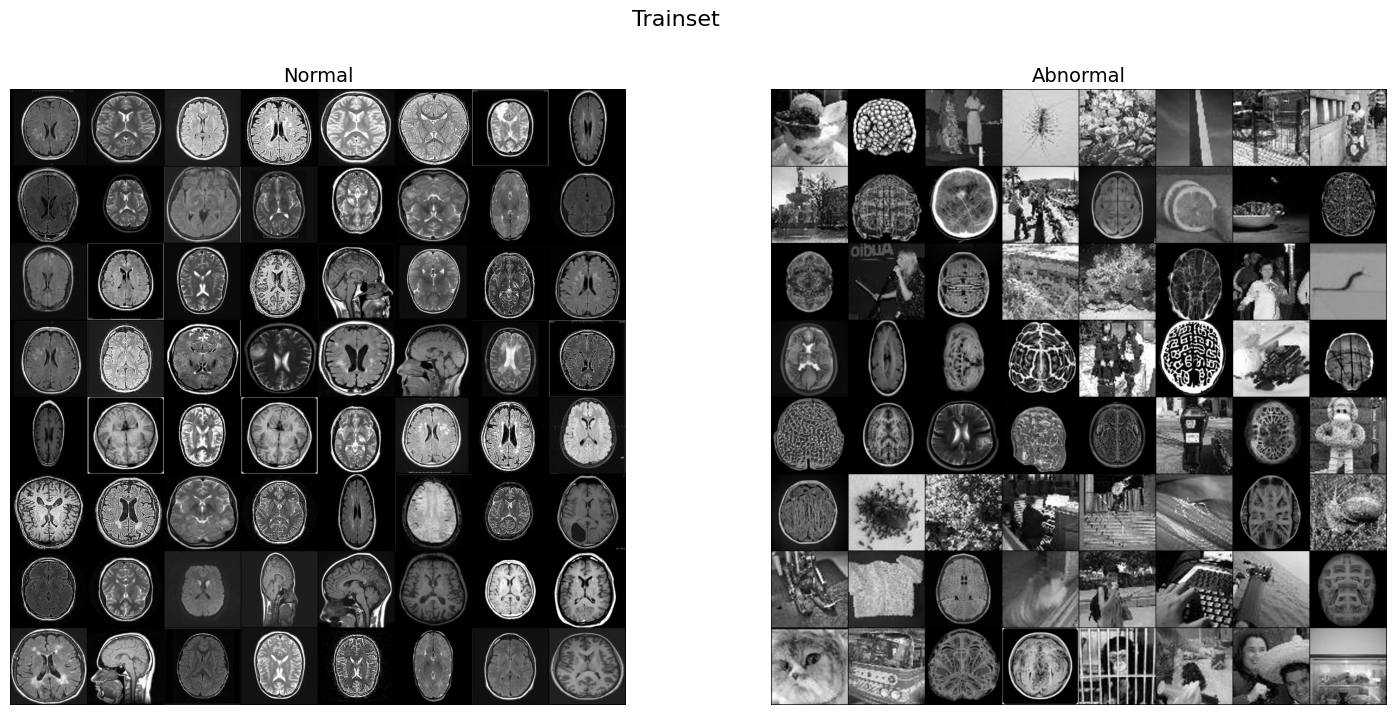

In [16]:
visualize_samples(trainloader, 8, "Trainset")

## Load Model

In [17]:
from torchvision.models import resnet18
resnet = torchvision.models.resnet18()
model = AdaptedModel(resnet).to(device)

## Training

In [18]:
from torchattacks import PGD 

torch.cuda.empty_cache()

attack_eps = 2/255
attack_steps = 10
attack_alpha = 2.5 * attack_eps / attack_steps

train_attack = PGD(model, eps=attack_eps, steps=attack_steps, alpha=attack_alpha)
test_attack = PGD(model, eps=attack_eps, steps=attack_steps, alpha=attack_alpha)

run(model, train_attack, test_attack, trainloader, test_loader, 1, 5, device, loss_threshold=1e-2, num_classes=1, learning_rate=0.1)

Starting Run from epoch 0
====== Starting Training on epoch 0


Epoch 1/5: 100%|██████████| 77/77 [02:46<00:00,  2.16s/batch, accuracy=68, loss=0.995] 


train loss is  0.995143627585197
AUC Vanila - Started...


100%|██████████| 85/85 [00:39<00:00,  2.15batch/s]


AUC Vanila - score on epoch 0 is: 83.91070212823482
AUC Adversarial - PGD-10 - Started...


100%|██████████| 85/85 [01:37<00:00,  1.15s/batch]


AUC Adversairal PGD-10 - score on epoch 0 is: 57.08599700636332
====== Starting Training on epoch 1


Epoch 2/5: 100%|██████████| 77/77 [02:40<00:00,  2.08s/batch, accuracy=80.9, loss=0.424]


train loss is  0.4240327959157983
AUC Vanila - Started...


100%|██████████| 85/85 [00:39<00:00,  2.17batch/s]


AUC Vanila - score on epoch 1 is: 87.14687745014908
AUC Adversarial - PGD-10 - Started...


100%|██████████| 85/85 [01:37<00:00,  1.15s/batch]


AUC Adversairal PGD-10 - score on epoch 1 is: 67.64124533319568
====== Starting Training on epoch 2


Epoch 3/5: 100%|██████████| 77/77 [02:39<00:00,  2.07s/batch, accuracy=84.7, loss=0.339]


train loss is  0.3386149888135949
AUC Vanila - Started...


100%|██████████| 85/85 [00:39<00:00,  2.16batch/s]


AUC Vanila - score on epoch 2 is: 88.1742503004697
AUC Adversarial - PGD-10 - Started...


100%|██████████| 85/85 [01:37<00:00,  1.15s/batch]


AUC Adversairal PGD-10 - score on epoch 2 is: 69.04574758579669
====== Starting Training on epoch 3


Epoch 4/5: 100%|██████████| 77/77 [02:39<00:00,  2.07s/batch, accuracy=85.4, loss=0.325]


train loss is  0.3245364806360128
AUC Vanila - Started...


100%|██████████| 85/85 [00:39<00:00,  2.15batch/s]


AUC Vanila - score on epoch 3 is: 89.17473449293742
AUC Adversarial - PGD-10 - Started...


100%|██████████| 85/85 [01:38<00:00,  1.15s/batch]


AUC Adversairal PGD-10 - score on epoch 3 is: 69.3060317600765
====== Starting Training on epoch 4


Epoch 5/5: 100%|██████████| 77/77 [02:40<00:00,  2.08s/batch, accuracy=85.9, loss=0.316]


train loss is  0.3155177544331064
AUC Vanila - Started...


100%|██████████| 85/85 [00:38<00:00,  2.19batch/s]


AUC Vanila - score on epoch 4 is: 88.45862120664695
AUC Adversarial - PGD-10 - Started...


100%|██████████| 85/85 [01:37<00:00,  1.15s/batch]

AUC Adversairal PGD-10 - score on epoch 4 is: 69.03213120878526


## Testing

In [19]:
# CLEAN
print(f'AUC Clean - Started...')
auc = auc_softmax(model=model, test_loader=test_loader, device=device, num_classes=1)
print(f'AUC Clean - score is: {auc * 100}')

AUC Clean - Started...


100%|██████████| 85/85 [00:39<00:00,  2.18batch/s]

AUC Clean - score is: 88.45862120664695


In [20]:
# PGD-100
test_attack = PGD(model, eps=attack_eps, steps=100, alpha=2.5 * (attack_eps)/100)
print(f'AUC Adversarial - Started...')
adv_auc = auc_softmax_adversarial(model=model, test_attack=test_attack, test_loader=test_loader, device=device, num_classes=1)
print(f'AUC Adversarial PGD-100 - score is: {adv_auc * 100}')

AUC Adversarial - Started...


 100%|██████████| 85/85 [10:28<00:00, 7.39s/batch]

AUC Adversarial PGD-100 - score is: 68.730603176066
